## Litics360 Prototype Version Pv1.0
# Data Cleaning & Feature Engineering


### Data Cleaning -- Goals:

#1. Get rid of unnecessary features (any features with 80000 missing)
#2. Get rid of rows that do not contain voter id or congressional district id

### Feature Engineering -- Goals:
#1. Include Congressional District Representative and their Party affiliation -- merge to main data
#2. 

--------------------------------------------------------------------------------------------------------------------
# Library Imports

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.html import read_html

import seaborn as sb

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn import metrics
%matplotlib inline

--------------------------------------------------------------------------------------------------------------------
# Data Import & Data Info/Preview

In [22]:
#Import Data
df = pd.read_csv(
    "data/VoterData/explore_clean/explore_clean_RAW_voterdata.csv",
    sep=",", quotechar='"', header=0, encoding='ISO-8859-1', na_values=['NA'],low_memory=False)

In [23]:
df.head()

,SOS_VOTERID,COUNTY_NUMBER,COUNTY_ID,LAST_NAME,FIRST_NAME,MIDDLE_NAME,SUFFIX,DATE_OF_BIRTH,REGISTRATION_DATE,VOTER_STATUS,...,GENERAL-11/08/2016,PRIMARY-05/02/2017,PRIMARY-09/12/2017,GENERAL-11/07/2017,PRIMARY-05/08/2018,GENERAL-08/07/2018,GENERAL-11/06/2018,PRIMARY-05/07/2019,PRIMARY-09/10/2019,GENERAL-11/05/2019
0,OH0012544778,53,4028,MOORE,PATRICIA,ANN,NaN,1949-07-15,1979-06-30,ACTIVE,...,X,NaN,NaN,X,R,NaN,X,NaN,NaN,NaN
1,OH0014738737,18,583025,FISHER,HUGH,PARES,NaN,1962-11-03,2005-05-27,ACTIVE,...,X,NaN,NaN,X,NaN,NaN,X,NaN,NaN,NaN
2,OH0012992671,48,89008187,YODER,RITA,S,NaN,1965-03-12,2000-11-20,ACTIVE,...,X,NaN,NaN,NaN,R,NaN,X,NaN,NaN,NaN
3,OH0014594730,18,297309,SMOTHERS,MICHAEL,L,NaN,1952-08-18,2012-10-06,ACTIVE,...,X,NaN,NaN,X,D,NaN,X,NaN,NaN,NaN
4,OH0013839801,31,523994,GEORGE,SHERYL,A,NaN,1955-06-08,1989-07-17,ACTIVE,...,X,NaN,NaN,NaN,X,NaN,X,NaN,NaN,X


In [24]:
#Number of rows, number of columns
df.shape

(87513, 108)

In [25]:
#Info about file
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87513 entries, 0 to 87512
Columns: 108 entries, SOS_VOTERID to GENERAL-11/05/2019
dtypes: float64(16), int64(2), object(90)
memory usage: 72.1+ MB


--------------------------------------------------------------------------------------------------------------------
# Data Prep&Clean

In [26]:
#Features list
features = list(df)
demographic_feature = features[:46]
vote_feature  = features[46:]

#Feature dtypes list
dtypes = list(df.dtypes)

#Missing values for each feature - Output:Bool
na_bool = np.array(df.isna().any())

#Missing values for each feature - Output:Number of missing values
num_na = np.array(df.isnull().sum())

#Data info dataframe -- demographic features for display
demographicfeature_dtypelist = pd.DataFrame(list(zip(demographic_feature,dtypes, na_bool, num_na)),
                                            columns = ['feature','dtype', 'na_bool', 'num_na'])

#Demographic feature and number of na
dem_df  = pd.DataFrame(list(zip(demographic_feature, num_na)),
                       columns = ['feature','num_na'])

#Data info dataframe -- voting features for display
votefeature_dtypelist = pd.DataFrame(list(zip(vote_feature,dtypes, na_bool, num_na)),
                                     columns = ['feature','dtype', 'na_bool', 'num_na'])

#Voting feature and number of na
vote_df= pd.DataFrame(list(zip(vote_feature, num_na)),
                      columns = ['feature','num_na'])

#90%  of missing values count for any given dataframe
na_pct = 0.9 * len(df)

#List of demographic feature columns to drop: If number of missing values for feature is over 80000
drop_demographic_features = dem_df.loc[dem_df['num_na'] > na_pct]

#Drop the columns that are in the list of features with over 80000 missing values
df = df.drop(labels=drop_demographic_features.feature, axis=1)

#Drop rows with missing SOS_VOTERID value
df = df[pd.notnull(df['SOS_VOTERID'])]

#Drop rows with missing CONGRESSIONAL_DISTRICT value
df = df[pd.notnull(df['CONGRESSIONAL_DISTRICT'])]

#Convert CONGRESSIONAL_DISTRICT from float to int
df["CONGRESSIONAL_DISTRICT"]= df["CONGRESSIONAL_DISTRICT"].astype(int) 

df.shape

(87509, 91)

In [27]:
#Unique types of party affiliations listed in dataset
parties = df.PARTY_AFFILIATION.unique()

#Party affiliation declared as R(republican)
R_party = df[(df['PARTY_AFFILIATION']=='R')]

#Party affiliation declared as D(democrat)
D_party = df[(df['PARTY_AFFILIATION']=='D')]

#Party affiliation declared as G(green)
G_party = df[(df['PARTY_AFFILIATION'] =='G')]

#Party affiliation declared as L(libertarian)
L_party = df[(df['PARTY_AFFILIATION'] =='L')]


print(
    "Party Affiliations and number of registered voters listed in THIS dataset: \n",
      parties,
      "\n\n----For reference----",
      "\n-->D = Democrat; #Voters:", len(D_party),
      "\n-->R = Republican; #Voters:",len(R_party),
      "\n-->G = Green; #Voters:", len(G_party),
      "\n-->L = Libertarian; #Voters:", len(L_party),
     )        

Party Affiliations and number of registered voters listed in THIS dataset: 
 ['R' 'D' 'G'] 

----For reference---- 
-->D = Democrat; #Voters: 36143 
-->R = Republican; #Voters: 51187 
-->G = Green; #Voters: 179 
-->L = Libertarian; #Voters: 0


--------------------------------------------------------------------------------------------------------------------
# Feature Engineering -- Congressional_District Reps

In [28]:
#Pull in Congressional District Representatives for all states from official page
page = 'https://www.house.gov/representatives'

#Pull in all tables containing House of Reps info
all_reps = pd.read_html(page,attrs={'class':'table'})

#Ohio district is the 38th table
#Pull in 38th table and get rid of the unnecessary columns
ohio_reps = all_reps[38].drop(axis=1, labels=['Phone', 'Office Room', 'Committee Assignment'])


#Clean OHIO_REPS dataframe
    #1. Rename district values to only numeric-- get rid of st/rd/th
    #2. Turn district from STR to INT
    #3. Drop all cols except district, name, party
    #4. Rename District to CONGRESSIONAL_DISTRICT, party to CONGRESSIONAL_DISTRICT_REP_PARTY
    #5. Merge with df

#Iterate over each row
for index_label, row_series in ohio_reps.iterrows():

    # For each row update the 'District' value -- by removing the last two chracters
    ohio_reps.at[index_label , 'District'] = row_series['District'][:len(row_series['District'])-2]

#Turn all values for District and CONGRESSIONAL_DISTRICT col to INT
ohio_reps['District'] = pd.to_numeric(ohio_reps['District'])

#Rename District to CONGRESSIONAL_DISTRICT, party to CONGRESSIONAL_DISTRICT_REP_PARTY
ohio_reps.rename(columns={'District':'CONGRESSIONAL_DISTRICT',
                          'Party':'CD_REP_PARTY', 
                          'Name':'CD_REP_NAME'}, 
                 inplace=True)

df = pd.merge(df, ohio_reps, on='CONGRESSIONAL_DISTRICT')
df.head()

,SOS_VOTERID,COUNTY_NUMBER,COUNTY_ID,LAST_NAME,FIRST_NAME,MIDDLE_NAME,DATE_OF_BIRTH,REGISTRATION_DATE,VOTER_STATUS,PARTY_AFFILIATION,...,PRIMARY-09/12/2017,GENERAL-11/07/2017,PRIMARY-05/08/2018,GENERAL-08/07/2018,GENERAL-11/06/2018,PRIMARY-05/07/2019,PRIMARY-09/10/2019,GENERAL-11/05/2019,CD_REP_NAME,CD_REP_PARTY
0,OH0012544778,53,4028,MOORE,PATRICIA,ANN,1949-07-15,1979-06-30,ACTIVE,R,...,NaN,X,R,NaN,X,NaN,NaN,NaN,"Johnson, Bill",R
1,OH0016094741,44,33881,PARNELL,RUTH,AULENE,1938-05-23,1964-05-27,ACTIVE,R,...,NaN,X,R,NaN,X,NaN,NaN,X,"Johnson, Bill",R
2,OH0011521605,15,9204837,HENDERSON,JOYCE,ANN,1970-12-16,1992-09-25,ACTIVE,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Johnson, Bill",R
3,OH0012329173,30,28228,CAPLES,JEFFERY,LEE,1955-11-24,1996-10-06,ACTIVE,R,...,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,"Johnson, Bill",R
4,OH0018218025,7,16917,MATUSKA,KRISTINA,M,1972-10-13,2008-12-09,ACTIVE,D,...,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,"Johnson, Bill",R


--------------------------------------------------------------------------------------------------------------------
# Feature Engineering -- CPVI (Cook Partisan Voting Index)

In [29]:
#Pull in Congressional District Representatives for Ohio from Wiki
page_CPVI = 'https://en.wikipedia.org/wiki/United_States_congressional_delegations_from_Ohio'

#Pull in all tables
table_CPVI = pd.read_html(page_CPVI,attrs={'class':'wikitable'})

CD_CPVI = pd.DataFrame(table_CPVI[0])

CD_CPVI = CD_CPVI.drop(axis=1, labels=['Representative(Residence)', 'Party', 'Incumbency', 'District map'])

#Clean table_CPVI dataframe
    #1. Rename district values to only numeric-- get rid of st/rd/th
    #2. Turn district from STR to INT
    #3. Drop all cols except district and cpvi
    #4. Rename District to CONGRESSIONAL_DISTRICT, CPVI to CD_REP
    #5. Merge with df

#Iterate over each row
for index_label, row_series in CD_CPVI.iterrows():

    # For each row update the 'District' value -- by removing the last two chracters
    CD_CPVI.at[index_label , 'District'] = row_series['District'][:len(row_series['District'])-2]
    CD_CPVI.at[index_label , 'CPVI'] = row_series['CPVI'][2:len(row_series['CPVI'])]
    
#Turn all values for District and CONGRESSIONAL_DISTRICT col to INT
CD_CPVI['District'] = pd.to_numeric(CD_CPVI['District'])
CD_CPVI['CPVI'] = pd.to_numeric(CD_CPVI['CPVI'])

#Rename District to CONGRESSIONAL_DISTRICT, CPVI to CD_REP_CPVI
CD_CPVI.rename(columns={'District':'CONGRESSIONAL_DISTRICT',
                        'CPVI':'CD_REP_CPVI'},
               inplace=True)

df = pd.merge(df, CD_CPVI, on='CONGRESSIONAL_DISTRICT')
df.head()

,SOS_VOTERID,COUNTY_NUMBER,COUNTY_ID,LAST_NAME,FIRST_NAME,MIDDLE_NAME,DATE_OF_BIRTH,REGISTRATION_DATE,VOTER_STATUS,PARTY_AFFILIATION,...,GENERAL-11/07/2017,PRIMARY-05/08/2018,GENERAL-08/07/2018,GENERAL-11/06/2018,PRIMARY-05/07/2019,PRIMARY-09/10/2019,GENERAL-11/05/2019,CD_REP_NAME,CD_REP_PARTY,CD_REP_CPVI
0,OH0012544778,53,4028,MOORE,PATRICIA,ANN,1949-07-15,1979-06-30,ACTIVE,R,...,X,R,NaN,X,NaN,NaN,NaN,"Johnson, Bill",R,16
1,OH0016094741,44,33881,PARNELL,RUTH,AULENE,1938-05-23,1964-05-27,ACTIVE,R,...,X,R,NaN,X,NaN,NaN,X,"Johnson, Bill",R,16
2,OH0011521605,15,9204837,HENDERSON,JOYCE,ANN,1970-12-16,1992-09-25,ACTIVE,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Johnson, Bill",R,16
3,OH0012329173,30,28228,CAPLES,JEFFERY,LEE,1955-11-24,1996-10-06,ACTIVE,R,...,NaN,NaN,NaN,X,NaN,NaN,NaN,"Johnson, Bill",R,16
4,OH0018218025,7,16917,MATUSKA,KRISTINA,M,1972-10-13,2008-12-09,ACTIVE,D,...,NaN,NaN,NaN,X,NaN,NaN,NaN,"Johnson, Bill",R,16


--------------------------------------------------------------------------------------------------------------------
# Feature Engineering -- 

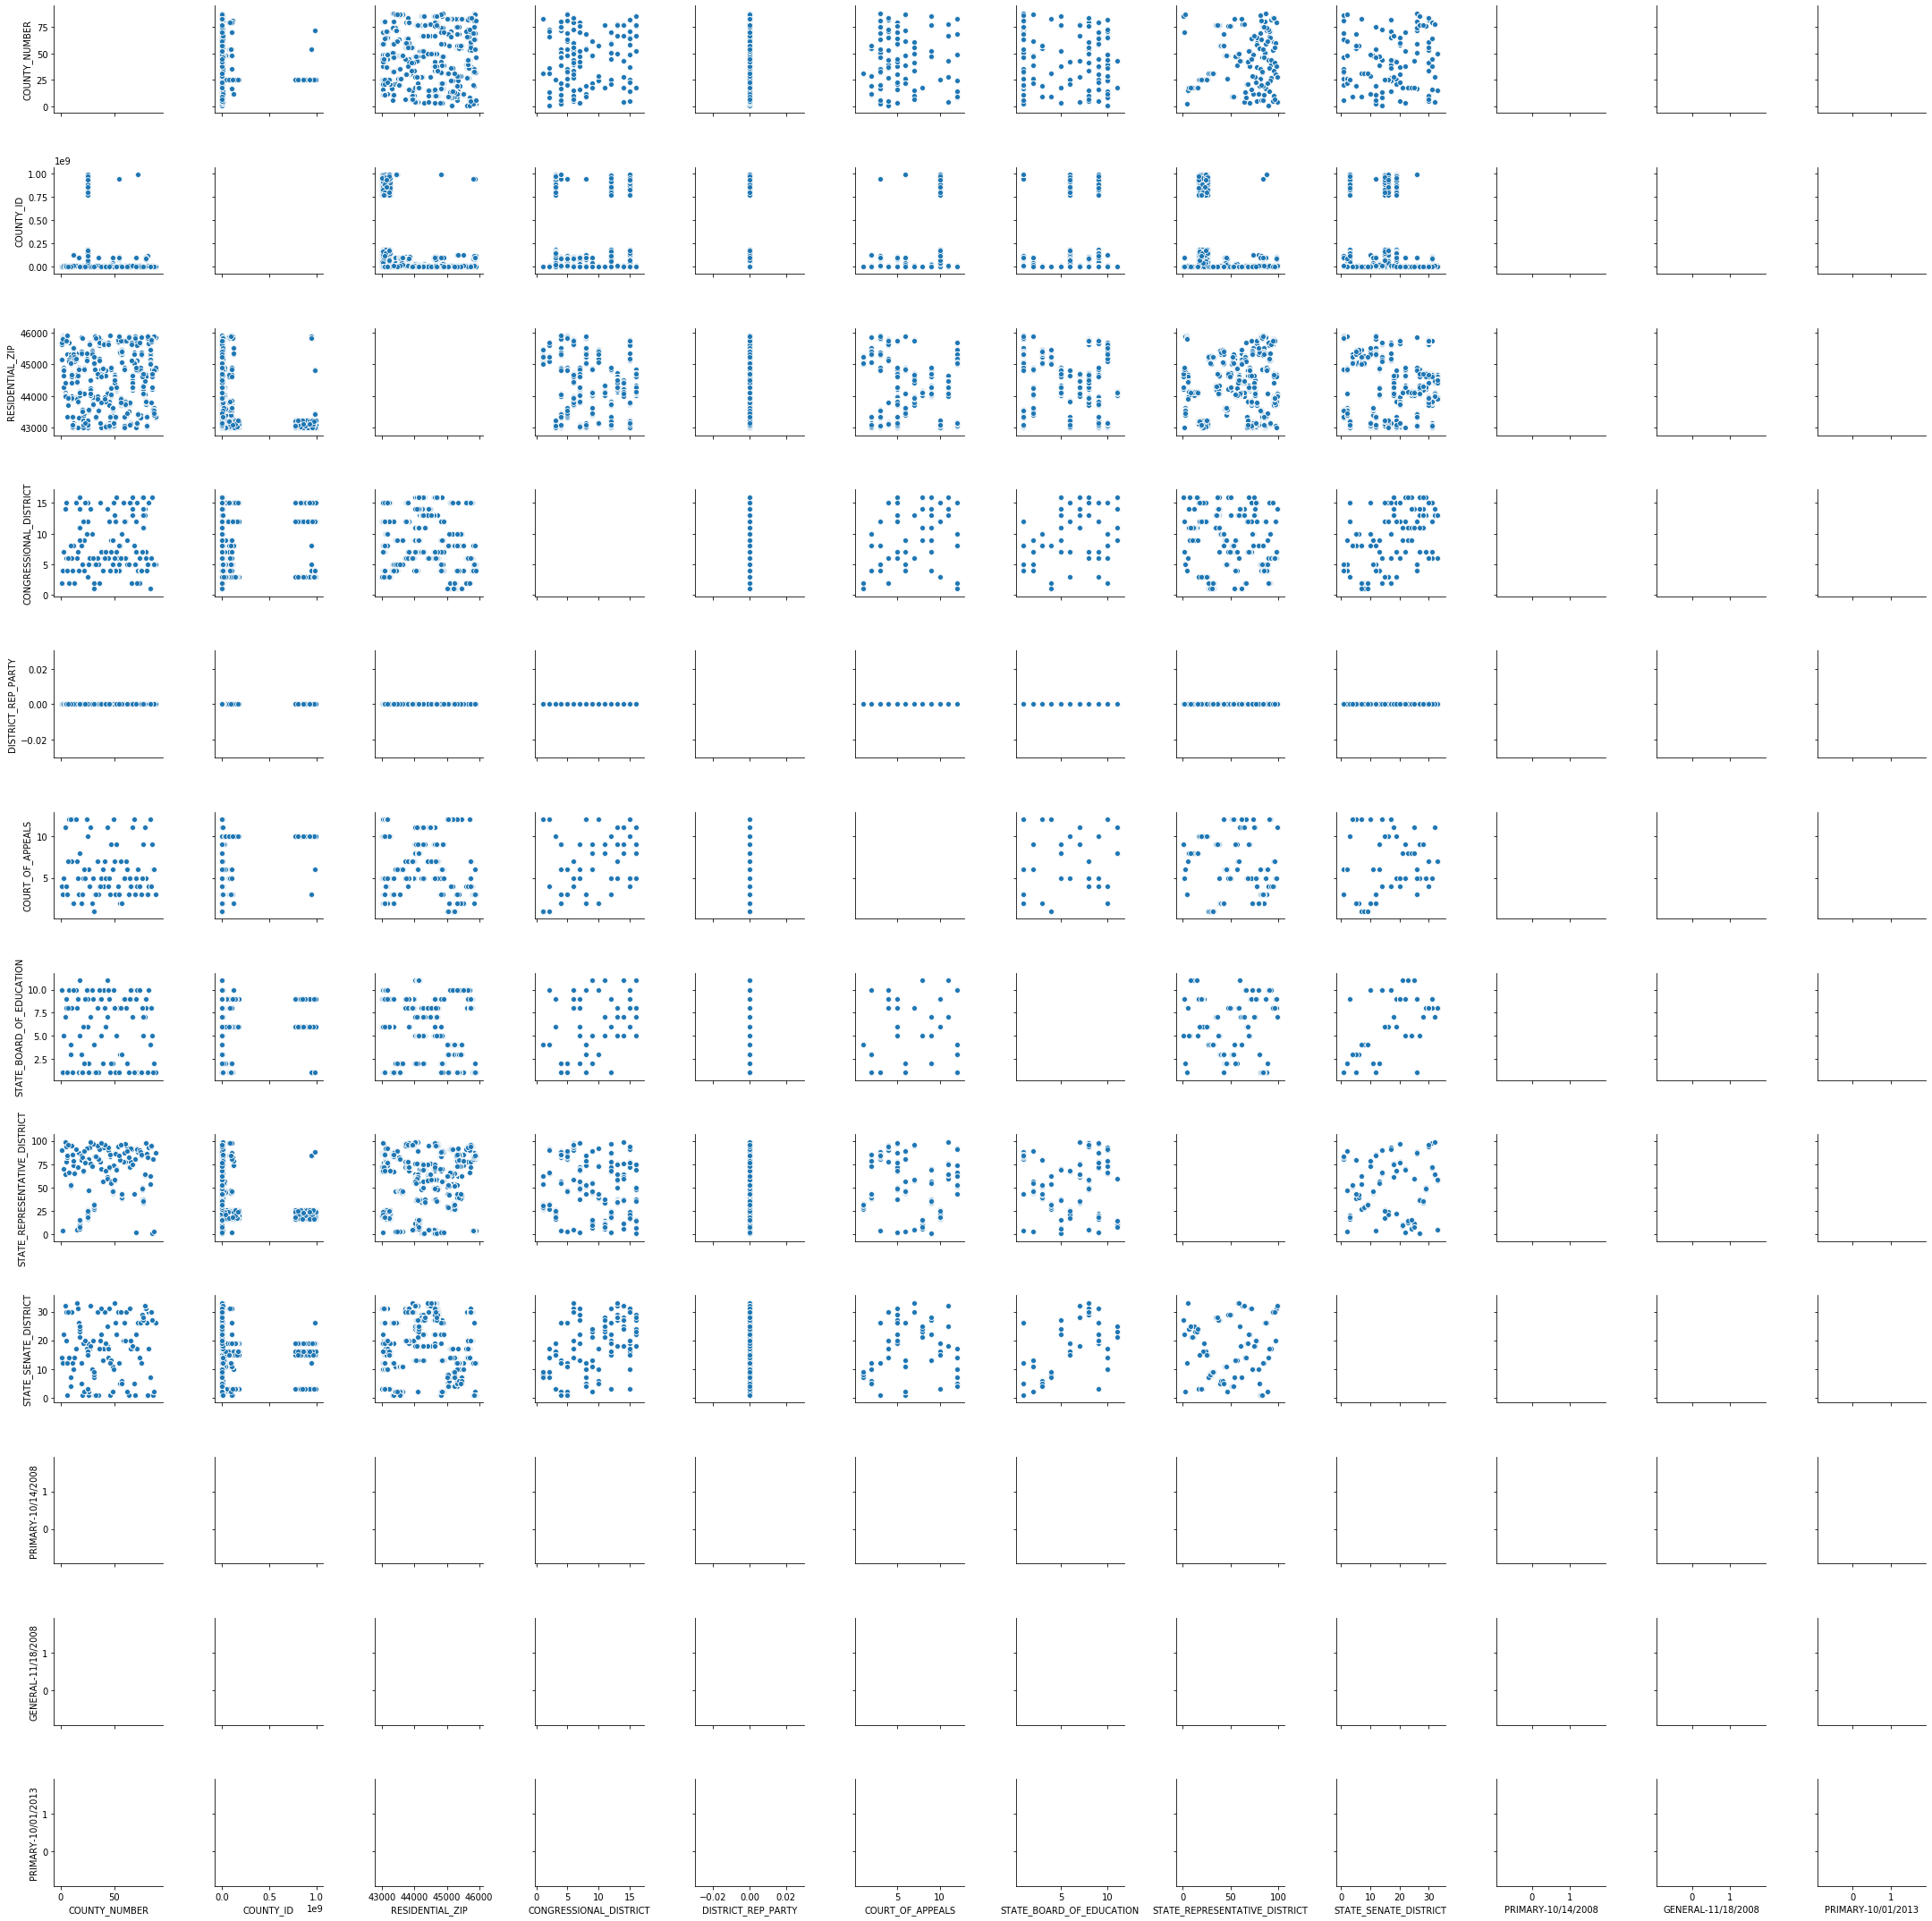

In [504]:
sb.pairplot(df,diag_kind='reg') # Check if we have any correlation among variables in our dataset.

In [31]:
# calculate Pearsons correlation to find of the correlation is linear or not
corr = df.corr()
print('%.3f',corr)

%.3f                                COUNTY_NUMBER  COUNTY_ID  RESIDENTIAL_ZIP  \
COUNTY_NUMBER                       1.000000  -0.137355         0.104681   
COUNTY_ID                          -0.137355   1.000000        -0.353271   
RESIDENTIAL_ZIP                     0.104681  -0.353271         1.000000   
RESIDENTIAL_ZIP_PLUS4               0.007596   0.004258        -0.061196   
RESIDENTIAL_COUNTRY                      NaN        NaN              NaN   
RESIDENTIAL_POSTALCODE                   NaN        NaN              NaN   
MAILING_ZIP                         0.054128  -0.047939         0.327498   
MAILING_ZIP_PLUS4                   0.102469   0.020180        -0.003532   
MAILING_POSTAL_CODE                 0.216717  -0.090966        -0.206325   
CONGRESSIONAL_DISTRICT              0.069487  -0.045321        -0.286638   
COURT_OF_APPEALS                   -0.052895   0.224177        -0.397125   
LIBRARY                                  NaN        NaN              NaN   
STATE_B

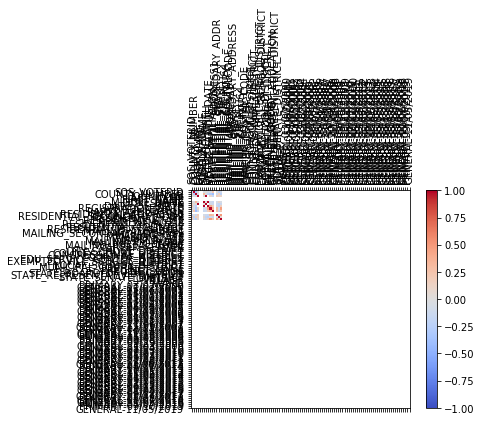

In [32]:
# Identify and plot correlations between variables in the dataset
corr = df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
plt.show()